In [0]:
# -*- coding: utf-8 -*-
"""
Created on Tue May 28 22:10:58 2019

@author: Donggeun Kwon (donggeun.kwon@gmail.com)

Cryptographic Algorithm Lab.
Graduate School of Information Security, Korea University
"""
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import keras
import keras.layers as layers

# when you use colab.
from google.colab import drive
drive.mount('/content/gdrive')

Using TensorFlow backend.


Go to this URL in a browser: www.github.com/DonggeunKwon

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
from datetime import datetime
now = datetime.now()

# Hyper parameter
total_epochs = 1000
batch_siz = 128
learning_rate = 0.001

# 추가적인 파라미터
len_seq = 30 # 몇일전 데이터를 입력할지


In [0]:
# Load the dataset
stock = pd.read_csv('/content/gdrive/My Drive/StockPrice.csv')
print(stock.head())

stock_data = np.array(stock.values[:-1, 1:].astype(np.float))
stock_data[np.isnan(stock_data)] = 0 # nan to zero

# Normalize
norm_stk = ((stock_data - np.min((stock_data.T), axis=1)) 
    / (np.max((stock_data.T), axis=1) - np.min((stock_data.T), axis=1) + 1e-7))

        년/월/일       종가       시가  ...  Unnamed: 11
0  2000-01-04  25750.0  24700.0  ...   0.000000    -0.022519   0.000000
1  2000-01-05  23100.0  24150.0  ...   0.000000    -0.027284   0.000000
2  2000-01-06  21900.0  23500.0  ...   0.000000    -0.102999   0.000000
3  2000-01-07  21700.0  21200.0  ...   0.007915     0.037041   0.003369
4  2000-01-10  21500.0  22000.0  ...   0.007198     0.000000   0.045153

[5 rows x 13 columns]


In [0]:
# 학습 주기 
# 현재는 다음날 데이터만 예측하도록 학습 
x = np.array([norm_stk[i:i+len_seq] 
                for i in range(norm_stk.shape[0] - len_seq)]) # 학습 데이터
high = np.array([norm_stk[i + len_seq, 2] 
                for i in range(norm_stk.shape[0] - len_seq)]) # 고가 
low = np.array([norm_stk[i + len_seq, 3] 
                for i in range(norm_stk.shape[0] - len_seq)]) # 저가 

In [0]:
# 학습 데이터와 테스트 데이터 분류 
y = high
# y = low

rand_idx = np.arange(0, len(x))
# np.random.shuffle(rand_idx) # 시간과 무관하게 샘플링 
num_training_data = int(len(x) * 0.95) # 학습 데이터 중 95% 이용
print('Training data number is ' + str(num_training_data))

training_idx = rand_idx[:num_training_data]
test_idx = rand_idx[num_training_data:]
x_train = x[training_idx]
y_train = y[training_idx]
x_test = x[test_idx]
y_test = y[test_idx]

Training data number is 4467


In [0]:
# LSTM 간단한 모델 설계 
inp = layers.Input(shape = (len_seq, 12))
bat1 = layers.BatchNormalization()(inp)
rnn1 = layers.LSTM(60, return_sequences=False)(bat1)
bat2 = layers.BatchNormalization()(rnn1)
dnn1 = layers.Dense(20, activation='sigmoid')(bat2)
bat3 = layers.BatchNormalization()(dnn1)
out = layers.Dense(1, activation = 'sigmoid')(bat3)

rnn_model_high = keras.Model(inp, out)
rnn_model_high.compile(optimizer=keras.optimizers.Adam(lr=learning_rate, 
                                                       decay=0.00001), 
                  loss = 'mean_squared_error')

rnn_model_high.summary(80)

Instructions for updating:
Colocations handled automatically by placer.
________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
input_1 (InputLayer)                (None, 30, 12)                  0           
________________________________________________________________________________
batch_normalization_1 (BatchNormali (None, 30, 12)                  48          
________________________________________________________________________________
lstm_1 (LSTM)                       (None, 60)                      17520       
________________________________________________________________________________
batch_normalization_2 (BatchNormali (None, 60)                      240         
________________________________________________________________________________
dense_1 (Dense)                     (None, 20)                      1220        
_____________________________________

In [0]:
savebest = keras.callbacks.ModelCheckpoint(now.strftime('%Y%m%d-%H%M%S') 
                                            + 'stock_price_high.h5', 
                                            monitor='val_loss', 
                                            save_best_only=True, 
                                            mode='min', period=1)

rnn_model_high.fit(x = x_train, y = y_train,
                   validation_data=[x_test, y_test],
                   batch_size=batch_siz,
                   epochs=total_epochs,
                   callbacks=[savebest])

Instructions for updating:
Use tf.cast instead.
Train on 4467 samples, validate on 236 samples
Epoch 1/1000
4467/4467 [==============================] - 5s 1ms/step - loss: 0.0492 - val_loss: 0.0465
Epoch 2/1000
4467/4467 [==============================] - 2s 394us/step - loss: 0.0229 - val_loss: 0.0475
Epoch 3/1000
4467/4467 [==============================] - 2s 401us/step - loss: 0.0127 - val_loss: 0.0477
Epoch 4/1000
4467/4467 [==============================] - 2s 395us/step - loss: 0.0099 - val_loss: 0.0481
Epoch 5/1000
4467/4467 [==============================] - 2s 400us/step - loss: 0.0061 - val_loss: 0.0466
Epoch 995/1000
4467/4467 [==============================] - 2s 387us/step - loss: 8.0082e-05 - val_loss: 1.2505e-04
Epoch 996/1000
4467/4467 [==============================] - 2s 380us/step - loss: 9.0224e-05 - val_loss: 8.4175e-04
Epoch 997/1000
4467/4467 [==============================] - 2s 409us/step - loss: 6.0011e-05 - val_loss: 6.0542e-04
Epoch 998/1000
4467/4467 [===

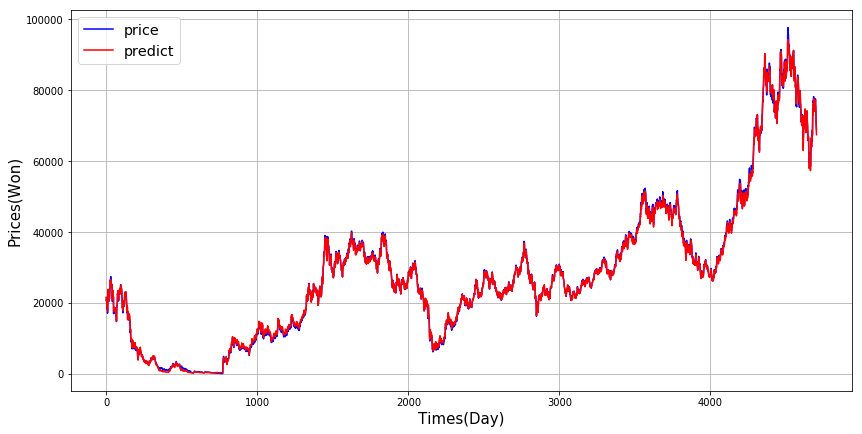

In [0]:
# 예측 원본 값으로 복원
rnn_model_high = keras.models.load_model(now.strftime('%Y%m%d-%H%M%S') + 'stock_price_high.h5')
y_pred = rnn_model_high.predict(x)
high_predict = ((y_pred * (np.max((stock_data.T)[2]) - np.min((stock_data.T)[2]) + 1e-7)) 
          + np.min((stock_data.T)[2]))
high_price = np.array([stock_data[i + len_seq, 2] for i in range(stock_data.shape[0] - len_seq)]) 

# 예측 그래프 시각화 
plt.figure(figsize=(14, 7))
plt.plot(high_price, color = 'blue', label='price')
plt.plot(high_predict, color = 'red', label='predict')
plt.xlabel('Times(Day)', size=15)
plt.ylabel('Prices(Won)', size=15)
plt.legend(loc='upper left', fontsize = 'x-large')
plt.grid(True)
plt.show()

In [0]:
# 학습 데이터와 테스트 데이터 분류 
# y = high
y = low

# high와 동일한 데이터 사용 
training_idx = rand_idx[:num_training_data]
test_idx = rand_idx[num_training_data:]
x_train = x[training_idx]
y_train = y[training_idx]
x_test = x[test_idx]
y_test = y[test_idx]

In [10]:
# LSTM 간단한 모델 설계 
inp_ = layers.Input(shape = (len_seq, 12))
bat1_ = layers.BatchNormalization()(inp_)
rnn1_ = layers.LSTM(60, return_sequences=False)(bat1_)
bat2_ = layers.BatchNormalization()(rnn1_)
dnn1_ = layers.Dense(20, activation='sigmoid')(bat2_)
bat3_ = layers.BatchNormalization()(dnn1_)
out_ = layers.Dense(1, activation = 'sigmoid')(bat3_)

rnn_model_low = keras.Model(inp_, out_)
rnn_model_low.compile(optimizer=keras.optimizers.Adam(lr=learning_rate, 
                                                      decay=0.00001), 
                  loss = 'mean_squared_error')

savebest_ = keras.callbacks.ModelCheckpoint(now.strftime('%Y%m%d-%H%M%S') 
                                            + 'stock_price_low.h5', 
                                            monitor='val_loss', 
                                            save_best_only=True, 
                                            mode='min', period=1)

rnn_model_low.fit(x = x_train, y = y_train,
                  validation_data=[x_test, y_test],
                  batch_size=batch_siz,
                  epochs=total_epochs,
                  callbacks=[savebest_])

Train on 4467 samples, validate on 236 samples
Epoch 1/1000
4467/4467 [==============================] - 3s 703us/step - loss: 0.0664 - val_loss: 0.0471
Epoch 2/1000
4467/4467 [==============================] - 2s 387us/step - loss: 0.0179 - val_loss: 0.0473
Epoch 3/1000
4467/4467 [==============================] - 2s 386us/step - loss: 0.0089 - val_loss: 0.0473
Epoch 4/1000
4467/4467 [==============================] - 2s 386us/step - loss: 0.0062 - val_loss: 0.0473
Epoch 5/1000
4467/4467 [==============================] - 2s 390us/step - loss: 0.0051 - val_loss: 0.0474
Epoch 995/1000
4467/4467 [==============================] - 2s 406us/step - loss: 7.6551e-05 - val_loss: 9.0966e-05
Epoch 996/1000
4467/4467 [==============================] - 2s 411us/step - loss: 9.7206e-05 - val_loss: 1.2621e-04
Epoch 997/1000
4467/4467 [==============================] - 2s 403us/step - loss: 1.0345e-04 - val_loss: 4.6179e-04
Epoch 998/1000
4467/4467 [==============================] - 2s 397us/step -

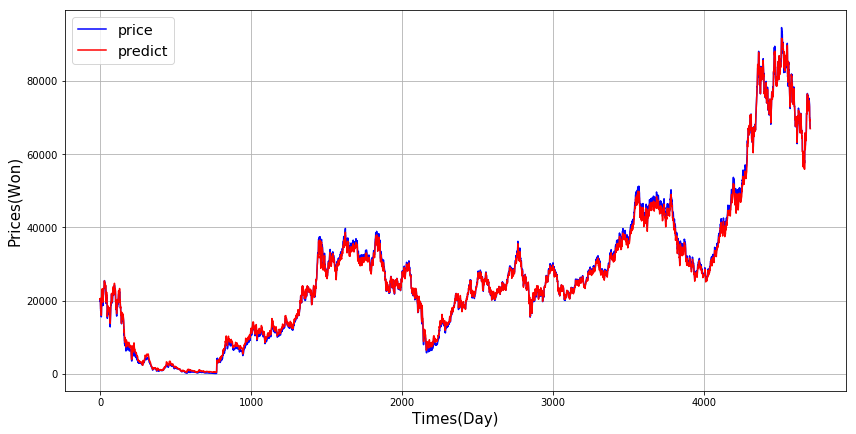

In [11]:
# 예측 원본 값으로 복원
rnn_model_low = keras.models.load_model(now.strftime('%Y%m%d-%H%M%S') + 'stock_price_low.h5')
y_pred = rnn_model_low.predict(x)
low_predict = ((y_pred * (np.max((stock_data.T)[3]) - np.min((stock_data.T)[3]) + 1e-7)) 
          + np.min((stock_data.T)[3]))
low_price = np.array([stock_data[i + len_seq, 3] for i in range(stock_data.shape[0] - len_seq)]) 

# 예측 그래프 시각화 
plt.figure(figsize=(14, 7))
plt.plot(low_price, color = 'blue', label='price')
plt.plot(low_predict, color = 'red', label='predict')
plt.xlabel('Times(Day)', size=15)
plt.ylabel('Prices(Won)', size=15)
plt.legend(loc='upper left', fontsize = 'x-large')
plt.grid(True)
plt.show()

In [0]:
import scipy
import scipy.io

# Save Result of Prediction
scipy.io.savemat('/content/gdrive/My Drive/' + 
                 now.strftime('%Y%m%d-%H%M%S') + '_prediction.mat', 
                 {'high_pred': high_predict,
                  'high_pric': high_price,
                  'low_pred' : low_predict,
                  'low_pric' : low_price})

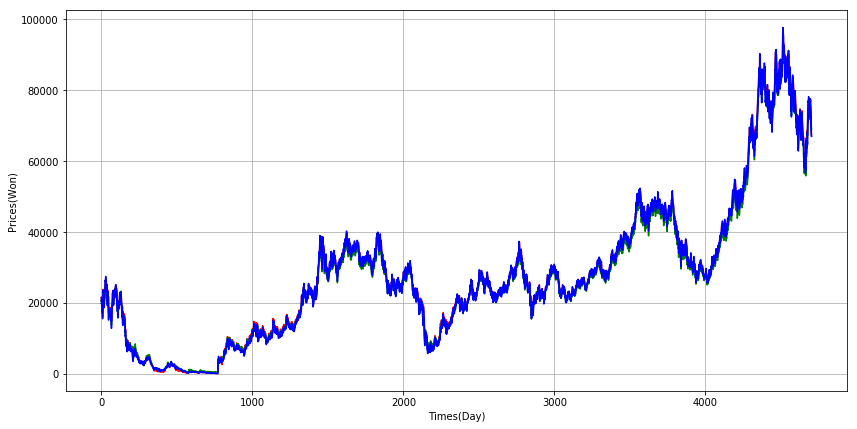

In [14]:
# 예측 그래프 시각화 
plt.figure(figsize=(14, 7))
plt.plot(high_predict, color = 'red')
plt.plot(low_predict, color = 'green')
plt.plot(low_price, color = 'blue')
plt.plot(high_price, color = 'blue')
plt.xlabel('Times(Day)', size=10)
plt.ylabel('Prices(Won)', size=10)
plt.grid(True)
plt.show()